In [1]:
import os
import nibabel as nib
import scipy.io as sio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nilearn.glm.first_level import make_first_level_design_matrix, run_glm
from nilearn.glm.contrasts import compute_contrast

from utils.psth import map_events_to_frame_times, get_trial_data, normalize_data

In [2]:
def get_task_idx(mat_data, task_type):
    for i, row in enumerate(mat_data['files_ML']['name']):
        filename = row[0][0]  
        
        if task_type.lower() == "audio" and ("audio" in filename.lower() or "aduio" in filename.lower()):
            return i
        if task_type.lower() == "video" and "video" in filename.lower():
            return i

    return None


def load_data(data_dir, brain_filename, event_filename, task_type='video'):
    brain_file = os.path.join(data_dir, brain_filename)
    event_file = os.path.join(data_dir, event_filename)

    brain_img = nib.load(brain_file)
    brain_data = brain_img.get_fdata()
    print(f"Brain data shape: {brain_data.shape}")

    mat_data = sio.loadmat(event_file)
    i = get_task_idx(mat_data, task_type)
    event_mat = mat_data['mldata'][0][i][0]

    return brain_data, event_mat

In [19]:
# Function to extract event-related information
def extract_event_info(event_mat, task_type='video'):
    if task_type == 'video':
        condition = event_mat[:]["Block"]
    elif task_type == 'audio':
        condition = event_mat[:]["Condition"]
    else:
        raise ValueError("Invalid task type. Must be 'video' or 'audio'")
    behave_codes = event_mat[:]["BehavioralCodes"]
    absolute_starttime = event_mat[:]["AbsoluteTrialStartTime"]
    return condition, behave_codes, absolute_starttime

def create_design_matrix(condition, behave_codes, absolute_starttime, task_type='video'):
    event_df = pd.DataFrame(columns=['onset', 'trial_type', 'duration', 'end', 'raw_onset'], index=range(len(condition)))

    for i, (c, b, s) in enumerate(zip(condition, behave_codes, absolute_starttime)):
        trial_start = s[0][0] if isinstance(s, np.ndarray) and s.ndim >= 2 else s
        trial_type = c[0][0]
        
        # Check if the specific index matches the condition
        if b[0][0][1][2][0] == 2:
            stimulus_onset = b[0][0][0][2][0] + trial_start
            trial_end = b[0][0][0][3] + trial_start
            
            if task_type == 'video':
                duration = 5
            elif task_type == 'audio':
                duration = 4
            else:
                raise ValueError("Invalid task type. Must be 'video' or 'audio'")
            
            event_df.at[i, 'raw_onset'] = stimulus_onset / 1000
            event_df.at[i, 'trial_type'] = str(trial_type)
            event_df.at[i, 'duration'] = duration
            event_df.at[i, 'end'] = trial_end / 1000
        else:
            # Skip this index if the condition is not met
            print(f"Skipping index {i} due to b[0][0][1][2][0] != 2")
            continue

    event_df['onset'] = event_df['raw_onset'] - absolute_starttime[0][0] / 1000 if isinstance(absolute_starttime[0], np.ndarray) else absolute_starttime[0] / 1000

    return event_df

In [32]:
# Function to create GLM design matrix
def create_glm_design_matrix(brain_data, event_df, tr=1/2.5, hrf_model='glover', drift_model='polynomial', drift_order=3):
    n_tr = brain_data.shape[-1]
    frame_times = np.arange(n_tr) * tr

    X = make_first_level_design_matrix(
        frame_times=frame_times,
        events=event_df,
        drift_model=drift_model,
        drift_order=drift_order,
        hrf_model=hrf_model
    )

    return X

In [33]:
def get_contrast_conditions(task_type, basic_contrasts):
    contrast_conditions = {}
    
    if task_type == 'video':
        contrast_conditions['non-social'] = basic_contrasts['non-social']
        contrast_conditions['social'] = basic_contrasts['social']
        contrast_conditions['social - non-social'] = basic_contrasts['social'] - basic_contrasts['non-social']

    elif task_type == 'audio':
        contrast_conditions['control'] = np.sum([basic_contrasts['1'], basic_contrasts['9'], basic_contrasts['10']], axis=0)
        contrast_conditions['ambiguous'] = np.sum([basic_contrasts['2'], basic_contrasts['4'], basic_contrasts['8']], axis=0)
        contrast_conditions['negative'] = np.sum([basic_contrasts['3'], basic_contrasts['5'], basic_contrasts['6']], axis=0)
        contrast_conditions['positive'] = basic_contrasts['7']
        contrast_conditions['positive - negative'] = contrast_conditions['positive'] - contrast_conditions['negative']
        contrast_conditions['positive - control'] = contrast_conditions['positive'] - contrast_conditions['control']
        contrast_conditions['positive - ambiguous'] = contrast_conditions['positive'] - contrast_conditions['ambiguous']
        contrast_conditions['negative - control'] = contrast_conditions['negative'] - contrast_conditions['control']
        contrast_conditions['negative - ambiguous'] = contrast_conditions['negative'] - contrast_conditions['ambiguous']
        contrast_conditions['control - ambiguous'] = contrast_conditions['control'] - contrast_conditions['ambiguous']

    return contrast_conditions

In [35]:
def run_glm_and_compute_contrasts(brain_data, X, task_type):
    Y = brain_data.reshape(-1, brain_data.shape[-1])
    labels, estimators = run_glm(Y.T, X.values)

    contrast_matrix = np.eye(X.shape[1])
    basic_contrasts = dict([(column, contrast_matrix[i]) for i, column in enumerate(X.columns)])
    
    # Get the contrast conditions based on the task type
    contrast_conditions = get_contrast_conditions(task_type, basic_contrasts)
    
    contrast_results = {}
    for contrast_id, contrast_value in contrast_conditions.items():
        contrast_vector = contrast_value if isinstance(contrast_value, np.ndarray) else basic_contrasts[contrast_value]
        contrast = compute_contrast(labels, estimators, contrast_vector, stat_type='t')
        contrast_results[contrast_id] = contrast.z_score()

    return contrast_results

In [7]:
data_dir = '/Users/yibeichen/Desktop/fusi/task_data/Grouper_socialvideo_data/'
brain_filename = 'Grouper_0227_Social_Videos_New_2Dscan_1.nii'
event_filename = 'mldata.mat'
task_type = 'video'

In [8]:
brain_data, event_mat = load_data(data_dir, brain_filename, event_filename, task_type)

pixdim[1,2,3] should be positive; setting to abs of pixdim values


Brain data shape: (128, 1, 153, 4500)


In [20]:
condition, behave_codes, absolute_starttime = extract_event_info(event_mat, task_type)
event_df = create_design_matrix(condition, behave_codes, absolute_starttime, task_type)

Skipping index 32 due to b[0][0][1][2][0] != 2
Skipping index 43 due to b[0][0][1][2][0] != 2


In [30]:
event_df1 = event_df.copy()
for i, row in event_df.iterrows():
    if row["trial_type"] == "2" or row["trial_type"] == "6":
        event_df1.at[i, "trial_type"] = "social"
    else:
        event_df1.at[i, "trial_type"] = "non-social"

In [45]:
event_df2 = event_df1.dropna(subset=['onset'])

X = create_glm_design_matrix(brain_data, event_df2, tr=1/2.5, hrf_model='glover', drift_model='polynomial', drift_order=3)
contrast_results = run_glm_and_compute_contrasts(brain_data, X, task_type)

/Users/yibeichen/micromamba/envs/neuro/lib/python3.10/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: raw_onset, end
  warnings.warn(


In [49]:
# Function to plot contrasts
def plot_contrasts(contrast_results, shape=(128, 153), vmin=-15, vmax=15):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes = axes.flatten()

    for i, (key, value) in enumerate(contrast_results.items()):
        sns.heatmap(value.reshape(*shape).T, ax=axes[i], cmap="bwr", vmin=vmin, vmax=vmax)
        axes[i].set_title(key)

    plt.tight_layout()
    plt.show()

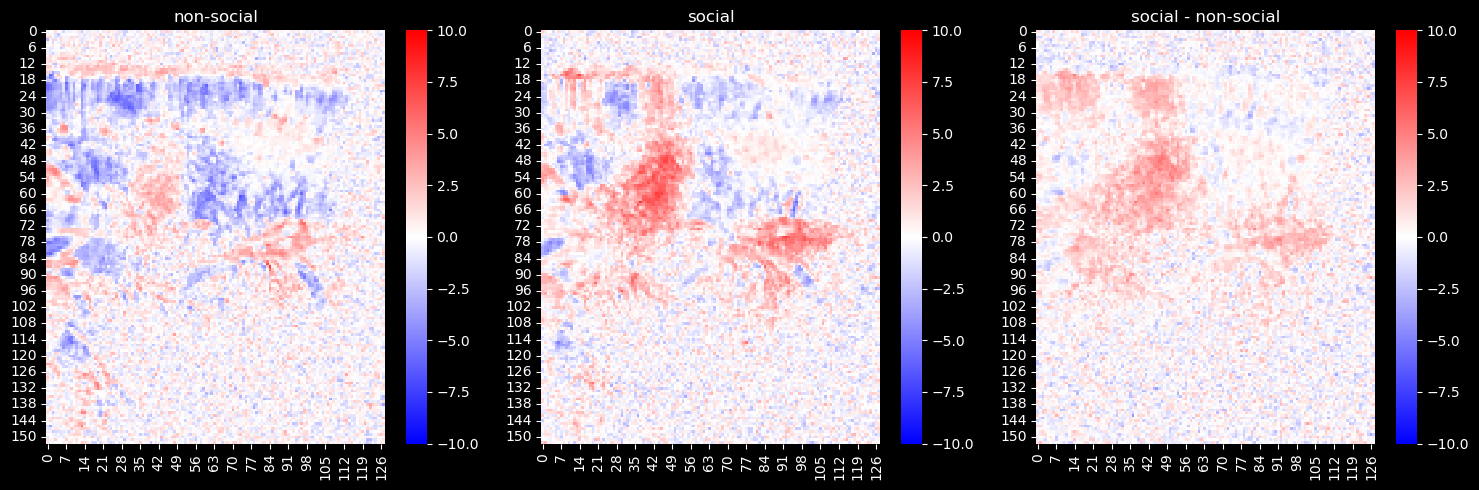

In [52]:
plot_contrasts(contrast_results, vmin=-10, vmax=10)